# Rede neural com camadas escondidas - Classificação do Iris dataset

O objetivo desse experimento é ilustrar o uso de rede neural que tenha mais de uma camada. Isso é conseguido com a inserção de uma ativação não linear entre as camadas.

Datasets utilizados:
    - Iris - 3 classes
    - Sintéticos:
        - meia luas
        - círculos circunscritos
        - blobs

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/Net2RegressaoSoftmaxArgmaxRede.png)

## Importando as bibliotecas

In [1]:
%matplotlib inline
from sklearn import datasets
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable
import torch.nn as nn

## Leitura, normalização e visualização dos dados

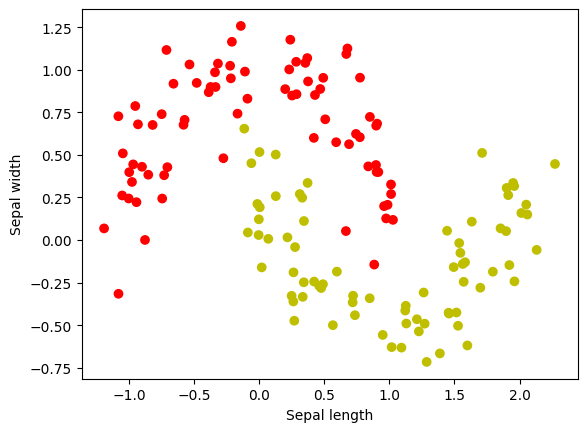

In [2]:
n_samples = 150
options = ['iris', 'moon', 'circles', 'blobs']
option = options[1]
if option == 'iris':
    iris = datasets.load_iris()
    X = iris.data[:,:2]  # comprimento das sépalas e pétalas, indices 0 e 2
    Xc = X - X.min(axis=0)
    Xc /= Xc.max(axis=0)
    Y = iris.target
elif option == 'moon':
    Xc,Y = datasets.make_moons(n_samples=n_samples, noise=.15)
elif option == 'circles':
    Xc,Y = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.1)
elif option == 'blobs':
    Xc,Y = datasets.make_blobs(n_samples=n_samples,centers=3,cluster_std=1.2)

colors = np.array(['r','y','b'])
plt.scatter(Xc[:, 0], Xc[:, 1], c=colors[Y])
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

### Prepara os dados para o PyTorch

In [3]:
X_tensor = torch.FloatTensor(Xc)
Y_tensor = torch.LongTensor(Y)

## Construindo o modelo da rede

In [17]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 10),      # camada 1
            nn.Sigmoid(),
            nn.Linear(10, 8),      # camada 2
            nn.Sigmoid(),
            nn.Linear(8, 3)        # camada de saída
)

    def forward(self, x):
        x = self.dense(x)

        return x

model = Modelo()
print(model)

Modelo(
  (dense): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=10, out_features=8, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=8, out_features=3, bias=True)
  )
)


## _predict_ utilizada para predição de classes e na visualização

In [18]:
def predict(model, inputs):
    outputs = model(Variable(inputs))
    _, predicts = torch.max(outputs, 1)

    return predicts.data.numpy()

## Classe para visualização dinâmica

In [19]:
class BoundaryPlotter():
    def __init__(self, model, X, Y, n_epoch, filepath=None, h = .01):
        self.model = model
        self.X = X
        self.Y = Y
        self.n_epoch = n_epoch
        self.filepath = filepath
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        self.xx, self.yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        self.loss_hist = []
        self.val_loss_hist = []
        self.X_grid = np.c_[self.xx.ravel(), self.yy.ravel()]

        #Gráficos a serem mostrados pelo callback
        self.fig = plt.figure(figsize=(8, 4), dpi=100)
        self.ax1 = self.fig.add_subplot(1, 2, 1)
        self.ax1.set_xlim(0, nb_epoch)
        self.ax1.set_xlabel('Epoca')#,fontsize=28)
        self.ax1.set_ylabel('Perda')#,fontsize=28)
        self.ax1.plot([],[],'b',linewidth = 2.0,label = "Treino")
        self.ax1.grid(True)

        self.ax2 = self.fig.add_subplot(1, 2, 2)
        self.ax2.set_xlim(Xc[:,0].min(), Xc[:,0].max())
        self.ax2.set_ylim(Xc[:,1].min(), Xc[:,1].max())
        self.ax2.set_xlabel('Comprimento da Sepala')#,fontsize=28)
        self.ax2.set_ylabel('Largura da Sepala')#,fontsize=28)

    def on_train_begin(self, logs={}):
        display.display(self.fig)
        display.clear_output(wait=True)

    def on_epoch_end(self, epoch, logs={}):
        if 'loss' in logs.keys():
            self.loss_hist.append(logs['loss'])

            if epoch%250==0:
                self.ax1.plot(np.arange(epoch+1), self.loss_hist, 'b', linewidth = 2.0)

                Z = predict(self.model, torch.from_numpy(self.X_grid).type(torch.FloatTensor))
#                 Z = torch.max(self.model(Variable(torch.FloatTensor(self.X_grid))).data, dim=1)[1].numpy()
                Z = Z.reshape(self.xx.shape)

                self.ax2.pcolormesh(self.xx, self.yy, Z, cmap=plt.cm.Paired)
                colors = np.array(['r','y','b'])
                self.ax2.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)

                display.display(self.fig)
                display.clear_output(wait=True)

## Treinamento

In [20]:
lr = 0.15

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

### Laço principal de treinamento

Final loss: tensor(0.2744)


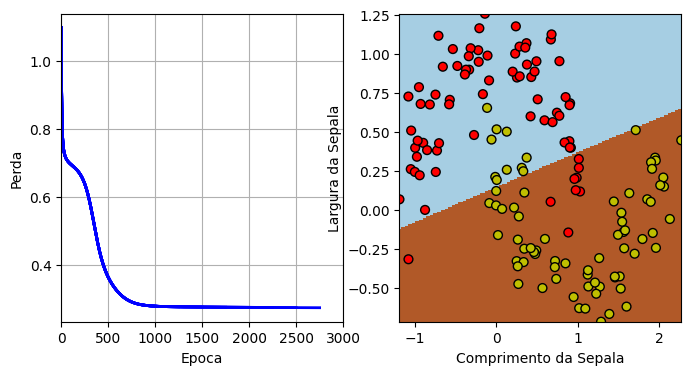

In [21]:
batch_size = 150
nb_epoch = 3000

#Definindo o plotter
boundary_plot = BoundaryPlotter(model, Xc, Y, nb_epoch)

boundary_plot.on_train_begin()
losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    loss = criterion(output, Variable(Y_tensor))

    # zero, backpropagation gradient, atualiza param gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data)

    boundary_plot.on_epoch_end(i, {'loss': loss.data})

print('Final loss:', loss.data)

## Avaliação

### Imprimindo pesos finais

In [22]:
for name, w in model.state_dict().items():
    print('{:16}{}'.format(name, w.size()))
    print(w)

dense.0.weight  torch.Size([10, 2])
tensor([[ 0.4053, -1.4832],
        [ 0.3913, -0.6452],
        [ 0.2755, -1.0755],
        [-0.3461,  1.1464],
        [ 0.1028,  1.3244],
        [ 0.1887,  0.3347],
        [ 0.1737, -0.6822],
        [ 0.2173, -1.0537],
        [ 0.4983, -0.4250],
        [-0.3140,  1.6566]])
dense.0.bias    torch.Size([10])
tensor([-0.5369,  0.2270,  0.0530,  0.1085, -0.4797,  0.2471, -0.1757,  0.2957,
         0.1794, -0.0455])
dense.2.weight  torch.Size([8, 10])
tensor([[-0.7721, -0.3455, -0.3119,  0.5729,  0.5047, -0.1722,  0.0995, -0.0606,
         -0.3362,  0.3468],
        [ 0.0434, -0.1821, -0.0701, -0.2695, -0.0017,  0.2996,  0.0246,  0.2718,
          0.2841,  0.0223],
        [-0.4600, -0.6128, -0.6052,  0.5421,  0.5364,  0.1644, -0.2696, -0.2536,
         -0.5465,  1.0666],
        [-1.3730, -0.3854, -0.9005,  0.7283,  0.9599,  0.3043, -0.6183, -0.9169,
         -0.2060,  1.5385],
        [ 0.7804,  0.2230,  0.0720, -0.3557, -0.1681,  0.1537,  0.3863,

### Avaliação do classificador

In [23]:
Y_hat = predict(model, X_tensor)
accuracy = (Y_hat == Y).mean()
print()
print('Training Accuracy: ', accuracy)


Training Accuracy:  0.8733333333333333


### Matriz de confusão

In [24]:
import pandas as pd
pd.crosstab(Y_hat, Y)

col_0,0,1
row_0,,
0,66,10
1,9,65


## Atividades

### Experimentos:

1. Faça alterações na rede, alterando o número de neurônios, de camadas. Escreva suas conclusões.
   - A rede pode aprender padrões mais complexos, formando fronteiras mais detalhadas, além de melhorar a acurácia em conjutos não linearmente separáveis. Importante ressaltar que a quantidade de dados também afeta o desempenho da rede, aumentar a rede exige mais dados
2. No lugar da ReLU, coloque Sigmoid e observe a diferença. O que aconteceu? Descreva.
   - A rede funciona, mas ReLu deu um resultado melhor. Isso fica bem evidenciado visualmente pelos gráficos. A convergência é mais lenta, pode travar o aprendizado e fronteiras aprendidas tendem a ser mais suaves, mas menos precisas em regiões complexas. Pode causar o problema de vanishing gradient.
3. O que ocorre quando não se utiliza ativação não linear entre camadas?
   - Toda a rede vira uma função linearmente composta, ou sejam é equivalente a uma única camada linear, independente de quantas camadas sejam colocadas. Dessa forma, a rede não é capaz de aprender relações complexas.
Referências:
- https://medium.com/@amanatulla1606/vanishing-gradient-problem-in-deep-learning-understanding-intuition-and-solutions-da90ef4ecb54

## Principais aprendizados

O grande aprendizado deste notebook foi a introdução das camadas ocultas com funções de ativação, responsáveis por adicionar não linearidades ao modelo. Isso permite que a rede aprenda padrões mais complexos, especialmente em conjuntos de dados que não são linearmente separáveis. Também é interessante notar como o código está consideravelmente mais enxuto, refletindo o acúmulo de conceitos já apresentados ao longo da disciplina. As abstrações oferecidas pelo PyTorch facilitam muito a construção de modelos, escondendo boa parte da complexidade matemática envolvida. Ainda assim, manter um sólido embasamento teórico continua sendo essencial para projetar redes eficazes, diagnosticar problemas de aprendizado e aplicar as ferramentas de forma consciente e robusta.